<a href="https://colab.research.google.com/github/aswarth123/Federated_Learning_MNIST/blob/main/FederatedLearning(SVM)_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
import copy
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

## SVM class

In [2]:
class SVM:

  def __init__(self, X_train, y_train, X_test, y_test, val=True, val_type='k_fold', k=5, opt='mini_batch_GD', batch_size = 30, n_iters=100, learning_rate=0.001, lambda_param=0.01):

    self.lr = learning_rate
    self.lambda_param = lambda_param
    self.n_iters = n_iters

    self.X_train = X_train
    self.y_train = y_train

    self.X_test = X_test
    self.y_test = y_test

    self.val = val
    self.val_type=val_type
    self.k=k

    self.opt = opt
    self.batch_size = batch_size

    self.w = np.array([])
    self.b = None

  def grad(self,x,y):
    if y * (np.dot(x, self.w) - self.b) >= 1:
      dw = self.lr * (2 * self.lambda_param * self.w)
      db = 0
    else:
      dw = self.lr * (2 * self.lambda_param * self.w - np.dot(x, y))
      db = self.lr * y

    return (dw,db)
  

  def stochastic_GD(self, X_train, y_train, X_val=None, y_val=None):
    n_samples, n_features = X_train.shape  
    y_ = np.where(y_train <= 0, -1, 1)
          
    if self.w.size == 0 and self.b is None :
      self.w = np.zeros(n_features)
      self.b = 0

    w_best = np.zeros(n_features)
    b_best = 0

    acc_list = [] 
    for i in range(0,self.n_iters):
      for idx, x_i in enumerate(X_train):
        dw,db = self.grad(x_i,y_[idx])
        self.w -= dw
        self.b -= db
    
      if i%10 == 0 and self.val:
        approx_w = np.dot(X_val, self.w) - self.b
        approx_w = np.sign(approx_w)
        res_w = np.where(approx_w<0, 0, approx_w)

        approx_w_best = np.dot(X_val, w_best) - b_best
        approx_w_best = np.sign(approx_w_best)
        res_w_best = np.where(approx_w_best<0, 0, approx_w_best)
            
        if (accuracy_score(y_val, res_w_best) < accuracy_score(y_val, res_w)):
          w_best = copy.deepcopy(self.w)
          b_best = copy.deepcopy(self.b)


  def batch_GD(self, X_train, y_train, X_val=None, y_val=None):
      n_samples, n_features = X_train.shape  
      y_ = np.where(y_train <= 0, -1, 1)
            
      if self.w.size == 0 and self.b is None :
        self.w = np.zeros(n_features)
        self.b = 0

      w_best = np.zeros(n_features)
      b_best = 0

      acc_list = [] 
      for i in range(0,self.n_iters):
        dw_sum=0
        db_sum=0
        for idx, x_i in enumerate(X_train):
          dw,db = self.grad(x_i,y_[idx])
          dw_sum+=dw
          db_sum+=db
        self.w -= (dw_sum/n_samples)
        self.b -= (db_sum/n_samples)
      
        if i%10 == 0 and self.val:
          approx_w = np.dot(X_val, self.w) - self.b
          approx_w = np.sign(approx_w)
          res_w = np.where(approx_w<0, 0, approx_w)

          approx_w_best = np.dot(X_val, w_best) - b_best
          approx_w_best = np.sign(approx_w_best)
          res_w_best = np.where(approx_w_best<0, 0, approx_w_best)
              
          if (accuracy_score(y_val, res_w_best) < accuracy_score(y_val, res_w)):
            w_best = copy.deepcopy(self.w)
            b_best = copy.deepcopy(self.b)


  def mini_batch_GD(self, X_train, y_train, X_val=None, y_val=None):
      n_samples, n_features = X_train.shape  
      y_ = np.where(y_train <= 0, -1, 1)
            
      if self.w.size == 0 and self.b is None :
        self.w = np.zeros(n_features)
        self.b = 0

      w_best = np.zeros(n_features)
      b_best = 0

      acc_list = [] 

      # print(self.n_iters)
      
      for i in range(0,self.n_iters):
        # print(i)
        dw_sum=0.0
        db_sum=0.0
        s=0
        for idx, x_i in enumerate(X_train):
          dw,db = self.grad(x_i,y_[idx])
          dw_sum+=dw
          db_sum+=db
          s += 1
          if s%self.batch_size==0:
            self.w -= (dw_sum/self.batch_size)
            self.b -= (db_sum/self.batch_size)
      
        if i%10 == 0 and self.val:
          approx_w = np.dot(X_val, self.w) - self.b
          approx_w = np.sign(approx_w)
          res_w = np.where(approx_w<0, 0, approx_w)

          approx_w_best = np.dot(X_val, w_best) - b_best
          approx_w_best = np.sign(approx_w_best)
          res_w_best = np.where(approx_w_best<0, 0, approx_w_best)
              
          if (accuracy_score(y_val, res_w_best) < accuracy_score(y_val, res_w)):
            w_best = copy.deepcopy(self.w)
            b_best = copy.deepcopy(self.b)


  def cross_validation(self, val_split):

    X_train = np.concatenate((self.X_train[0],self.X_train[1]),axis=0)
    y_train = np.concatenate((self.y_train[0],self.y_train[1]),axis=0)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_split, random_state=1, stratify=y_train)

    eval("self."+self.opt+"(X_train, y_train, X_val, y_val)")


  def k_fold_cross_validation(self):

    X = np.concatenate((self.X_train[0],self.X_train[1]),axis=0)
    y = np.concatenate((self.y_train[0],self.y_train[1]),axis=0)

    w_list = []
    b_list = []
    acc_list = []

    if self.w.size == 0 and self.b == None:
      w = np.zeros(self.X_train[0].shape[1])
      b = 0
    else:
      w = copy.deepcopy(self.w)
      b = self.b

    skf = StratifiedKFold(n_splits=self.k, shuffle=True)

    for train_index, val_index in skf.split(X,y):
      
      X_train, X_val = X[train_index], X[val_index]
      y_train, y_val = y[train_index], y[val_index]

      eval("self."+self.opt+"(X_train, y_train, X_val, y_val)")

      print(self.accuracy())
      w_list.append(self.w)
      b_list.append(self.b)

      test_w = np.dot(X_val, self.w) - self.b
      test_w = np.sign(test_w)
      res_val = np.where(test_w<0,0,test_w)

      acc_list.append(accuracy_score(y_val, res_val))
    
      self.w = copy.deepcopy(w)
      self.b = b

    self.w = copy.deepcopy(w_list[acc_list.index(max(acc_list))])
    self.b = b_list[acc_list.index(max(acc_list))]
  

  def fit(self):
    if self.val_type == 'k_fold' and self.val:
      self.k_fold_cross_validation()
    
    elif self.val_type == 'cross_val' and self.val:
      self.cross_validation(0.2)
    
    elif not self.val:
      X_train = np.concatenate((self.X_train[0],self.X_train[1]),axis=0)
      y_train = np.concatenate((self.y_train[0],self.y_train[1]),axis=0)
      X_train, y_train= shuffle(X_train, y_train)
      eval("self."+self.opt+"(X_train, y_train)")

  def predict(self):
     approx = np.dot(self.X_test, self.w) - self.b
     approx = np.sign(approx)
     return np.where(approx<0, 0, approx)

  def accuracy(self):
    return accuracy_score(self.y_test, self.predict())*100


## Federated SVM class

In [74]:
class Federated_SVM:

  def __init__(self, n_clients=3, val=True, val_type='k_fold', k=5, opt='mini_batch_GD', batch_size = 30, learning_rate=0.001, lambda_param=0.01, n_iters=100):
    self.n_clients = n_clients
    self.learning_rate = learning_rate
    self.lambda_param = lambda_param
    self.n_iters = n_iters
    self.val = val
    self.val_type = val_type
    self.client_distribution = []
    self.k = k
    self.opt = opt
    self.batch_size = batch_size
    self.X_test = None
    self.y_test = None
    
  def create_clients(self, X_train, y_train, X_test, y_test):
    self.clients=[]
    for i in range(self.n_clients):
      self.client_distribution.append(X_train[i][0].shape[0] + X_train[i][1].shape[0])
      self.clients.append(SVM(X_train[i],y_train[i], X_test, y_test, self.val, self.val_type, self.k, self.opt, self.batch_size, self.n_iters, self.learning_rate, self.lambda_param))
    self.X_test = copy.deepcopy(X_test)
    self.y_test = copy.deepcopy(y_test)
  

  def average_aggregator(self, parameter_list):
    w = np.zeros(parameter_list[0].shape[0])
    b = 0
    for i in range(0,2*self.n_clients,2):
        w = np.add(w,parameter_list[i]*self.client_distribution[i//2]/sum(self.client_distribution))
        b = b + parameter_list[i+1]*self.client_distribution[i//2]/sum(self.client_distribution)
    return (w, b)

  def highest_aggregator(self, parameter_list):
    score = 0

    for i in range(0,self.n_clients):
      acc = self.clients[i].accuracy()
      if (acc > score):
        w = copy.deepcopy(self.clients[i].w)
        b = self.clients[i].b
        score = acc

    return (w,b)

  def random_aggregator(self,parameter_list):
    n = random.randint(0,self.n_clients)
    w = np.zeros(parameter_list[0].shape[0])
    b = 0
    for i in range(0,2*self.n_clients,2):
      if i//2 != n:
        w = np.add(w,parameter_list[i]*self.client_distribution[i//2]/sum(self.client_distribution))
        b = b + parameter_list[i+1]*self.client_distribution[i//2]/sum(self.client_distribution)
      else:
        continue
    return (w, b)

  def fit(self, g_iters, aggregator):
    w_best = np.zeros(self.X_test.shape[1])
    b_best = 0
    for i in range(0,g_iters):
      print('global round',i+1)
      for j in range(0,self.n_clients):
        if i==0:
          self.clients[j].fit()
        else:
          self.clients[j].w = copy.deepcopy(w_agg)
          self.clients[j].b = copy.deepcopy(b_agg)
          self.clients[j].fit()
        print('client',j+1,self.clients[j].accuracy())          
      parameter_list = []
      for k in range(0,self.n_clients):
        parameter_list.append(self.clients[k].w)
        parameter_list.append(self.clients[k].b)
      w_agg, b_agg = aggregator(parameter_list)
      # print("agg",self.accuracy(w_agg,b_agg),"best",self.accuracy(w_best,b_best))
      if self.accuracy(w_agg,b_agg)>self.accuracy(w_best,b_best) or i==0:
        w_best=copy.deepcopy(w_agg)
        b_best=copy.deepcopy(b_agg)
      print('global test acc',self.accuracy(w_best,b_best))

  def predict(self,w,b):
     approx = np.dot(self.X_test, w) - b
     approx = np.sign(approx)
     return np.where(approx<0, 0, 1)
  
  def accuracy(self,w,b):
    return accuracy_score(self.y_test, self.predict(w,b))*100


## Utility functions

In [4]:
def create_kmeans_clusters(X, Y, n_clusters = 3, random_state = 0):
  clusters = KMeans(n_clusters=n_clusters, random_state=random_state).fit_predict(X)
  result = []
  for i in range(n_clusters):
    result.append(X[clusters == i])
    result.append(Y[clusters == i])
  return tuple(result)  

In [5]:
def load_mnist_return_required_digits(n1, n2):
  # Loading the mnist dataset and concatenating train - test sets
  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
  x_total = np.concatenate((x_train, x_test), axis=0)
  y_total = np.concatenate((y_train, y_test), axis=0)

  # Normalizing and reshaping the data
  x_total = x_total/255 
  x_total = x_total.reshape(x_total.shape[0],784)

  x_n1 = x_total[y_total == n1]
  y_n1 = y_total[y_total == n1]

  x_n2 = x_total[y_total == n2]
  y_n2 = y_total[y_total == n2]

  return [(x_n1, y_n1),(x_n2, y_n2)]

In [6]:
def get_clients(class1, class2, n_clients = 3):

  clients_X = []
  clients_y = []

  clientsXtest = []
  clientsYtest = []

  clusters_1 = KMeans(n_clusters=n_clients, random_state=0).fit_predict(class1)
  clusters_2 = KMeans(n_clusters=n_clients, random_state=0).fit_predict(class2)

  for i in range(n_clients):

    X_train0, X_test0, y_train0, y_test0 = train_test_split(class1[clusters_1 == i],np.zeros((class1[clusters_1 == i].shape[0],)),test_size=0.2)
    X_train1, X_test1, y_train1, y_test1 = train_test_split(class2[clusters_2 == i],np.ones((class2[clusters_2 == i].shape[0],)),test_size=0.2)

    clients_X.append([X_train0, X_train1])
    clients_y.append([y_train0, y_train1])

    clientsXtest.extend([X_test0,X_test1])
    clientsYtest.extend([y_test0,y_test1])

  X_test = np.concatenate(clientsXtest,axis=0)
  y_test = np.concatenate(clientsYtest,axis=0)

  return clients_X,clients_y,X_test,y_test

In [7]:
def get_total_from_clients(clients_X,clients_y):
  x_train0 = [i[0] for i in clients_X]
  x_train0 = np.concatenate(x_train0, axis=0)
  x_train1 = [i[1] for i in clients_X]
  x_train1 = np.concatenate(x_train1, axis=0)
  y_train0 = [i[0] for i in clients_y]
  y_train0 = np.concatenate(y_train0, axis=0)
  y_train1 = [i[1] for i in clients_y]
  y_train1 = np.concatenate(y_train1, axis=0)

  return ([x_train0,x_train1],[y_train0,y_train1])    

# Digits 0 and 6

### Loading the data of 0 and 6

In [93]:
data = load_mnist_return_required_digits(0, 6)

### Dividing the data of digits 0 and 6 into clusters using the KMeans algorithm
The images of 0 and 6 are divided into 3 three clusters each.

Text(0.5, 1.0, 'Cluster 3')

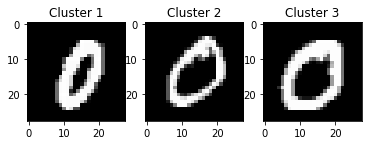

In [9]:
x_0_c1, y_0_c1, x_0_c2, y_0_c2, x_0_c3, y_0_c3 = create_kmeans_clusters(data[0][0], data[0][1])
fig, axs = plt.subplots(1, 3)
axs[0].imshow(x_0_c1[0].reshape(28,28),cmap='gray')
axs[0].set_title('Cluster 1')
axs[1].imshow(x_0_c2[0].reshape(28,28),cmap='gray')
axs[1].set_title('Cluster 2')
axs[2].imshow(x_0_c3[0].reshape(28,28),cmap='gray')
axs[2].set_title('Cluster 3')

Text(0.5, 1.0, 'Cluster 3')

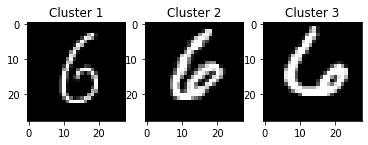

In [10]:
x_6_c1, y_6_c1, x_6_c2, y_6_c2, x_6_c3, y_6_c3 = create_kmeans_clusters(data[1][0], data[1][1])
fig, axs = plt.subplots(1, 3)
axs[0].imshow(x_6_c1[0].reshape(28,28),cmap='gray')
axs[0].set_title('Cluster 1')
axs[1].imshow(x_6_c2[0].reshape(28,28),cmap='gray')
axs[1].set_title('Cluster 2')
axs[2].imshow(x_6_c3[0].reshape(28,28),cmap='gray')
axs[2].set_title('Cluster 3')

### Creation of individual train sets for the clients, global train set for the SVM model and a global test set containing the data from all the clusters



In [94]:
clients_X,clients_y,X_test,y_test = get_clients(data[0][0], data[1][0], n_clients = 3)

In [95]:
xtrain_gl, ytrain_gl = get_total_from_clients(clients_X,clients_y)

### Federated learning model and SVM model training

#### Training the models without validation & with avg aggregator



In [13]:
f_svm = Federated_SVM(n_clients = 3, val=False, n_iters=150,opt='stochastic_GD')
f_svm.create_clients(clients_X,clients_y,X_test,y_test)

In [14]:
clf = SVM(xtrain_gl, ytrain_gl, X_test, y_test, val=False,n_iters=1000,opt='stochastic_GD')
clf.fit()
print(clf.accuracy())

98.98477157360406


In [15]:
f_svm.fit(10,f_svm.average_aggregator)

global round 1
client 1 92.89340101522842
client 2 90.50036258158084
client 3 92.5670775924583
global test acc 97.78825235678028
global round 2
client 1 92.85714285714286
client 2 91.18926758520666
client 3 93.4010152284264
global test acc 97.89702683103698
global round 3
client 1 93.69108049311095
client 2 91.37055837563452
client 3 92.27701232777375
global test acc 97.89702683103698
global round 4
client 1 93.21972443799855
client 2 91.11675126903553
client 3 94.19869470630891
global test acc 97.93328498912255
global round 5
client 1 94.16243654822335
client 2 89.15881073241479
client 3 91.9869470630892
global test acc 97.93328498912255
global round 6
client 1 93.43727338651196
client 2 89.99274836838289
client 3 93.61856417693981
global test acc 97.93328498912255
global round 7
client 1 92.89340101522842
client 2 89.70268310369833
client 3 92.13197969543148
global test acc 97.93328498912255
global round 8
client 1 94.12617839013778
client 2 89.88397389412619
client 3 94.017403915881

In [16]:
f_svm = Federated_SVM(n_clients = 3, val=False, n_iters=150,opt='batch_GD')
f_svm.create_clients(clients_X,clients_y,X_test,y_test)

In [17]:
clf = SVM(xtrain_gl, ytrain_gl, X_test, y_test, val=False,n_iters=1000,opt='batch_GD')
clf.fit()
print(clf.accuracy())

98.00580130529369


In [18]:
f_svm.fit(10,f_svm.average_aggregator)

global round 1
client 1 89.3763596809282
client 2 90.97171863669325
client 3 95.32269760696157
global test acc 96.62799129804206
global round 2
client 1 96.66424945612762
client 2 95.10514865844814
client 3 96.51921682378534
global test acc 96.99057287889775
global round 3
client 1 97.24437998549674
client 2 96.19289340101524
client 3 96.91805656272662
global test acc 97.35315445975344
global round 4
client 1 97.42567077592457
client 2 96.88179840464105
client 3 97.28063814358231
global test acc 97.53444525018129
global round 5
client 1 97.57070340826685
client 2 97.24437998549674
client 3 97.31689630166788
global test acc 97.67947788252357
global round 6
client 1 97.71573604060913
client 2 97.60696156635244
client 3 97.53444525018129
global test acc 97.78825235678028
global round 7
client 1 97.93328498912255
client 2 97.71573604060913
client 3 97.71573604060913
global test acc 97.86076867295141
global round 8
client 1 98.00580130529369
client 2 97.82451051486585
client 3 97.7157360406

In [19]:
f_svm = Federated_SVM(n_clients = 3, val=False, n_iters=150,opt='mini_batch_GD')
f_svm.create_clients(clients_X,clients_y,X_test,y_test)

In [20]:
clf = SVM(xtrain_gl, ytrain_gl, X_test, y_test, val=False,n_iters=1500,opt='mini_batch_GD')
clf.fit()
print(clf.accuracy())

95.32269760696157


In [21]:
f_svm.fit(10,f_svm.average_aggregator)

global round 1
client 1 92.71211022480058
client 2 88.86874546773024
client 3 92.71211022480058
global test acc 97.67947788252357
global round 2
client 1 93.4010152284264
client 2 89.44887599709934
client 3 86.94706308919507
global test acc 97.67947788252357
global round 3
client 1 93.4010152284264
client 2 89.23132704858592
client 3 94.52501812907904
global test acc 97.67947788252357
global round 4
client 1 90.89920232052212
client 2 88.21609862219
client 3 92.42204496011603
global test acc 97.67947788252357
global round 5
client 1 93.07469180565627
client 2 90.60913705583756
client 3 91.69688179840463
global test acc 97.67947788252357
global round 6
client 1 93.90862944162437
client 2 90.7904278462654
client 3 93.69108049311095
global test acc 97.71573604060913
global round 7
client 1 91.7331399564902
client 2 89.95649021029732
client 3 91.29804205946338
global test acc 97.89702683103698
global round 8
client 1 92.60333575054386
client 2 90.1015228426396
client 3 95.14140681653373
gl

#### Training the models with various validation & with avg aggregator & with batch GD

In [22]:
f_svm = Federated_SVM(n_clients = 3, val=False, n_iters=150,opt='batch_GD')
f_svm.create_clients(clients_X,clients_y,X_test,y_test)

In [23]:
clf = SVM(xtrain_gl, ytrain_gl, X_test, y_test, val=False, n_iters=1000,opt='batch_GD')
clf.fit()
print(clf.accuracy())

98.00580130529369


In [24]:
f_svm.fit(10,f_svm.average_aggregator)

global round 1
client 1 89.3763596809282
client 2 90.97171863669325
client 3 95.32269760696157
global test acc 96.62799129804206
global round 2
client 1 96.66424945612762
client 2 95.10514865844814
client 3 96.51921682378534
global test acc 96.99057287889775
global round 3
client 1 97.24437998549674
client 2 96.19289340101524
client 3 96.91805656272662
global test acc 97.35315445975344
global round 4
client 1 97.42567077592457
client 2 96.88179840464105
client 3 97.28063814358231
global test acc 97.53444525018129
global round 5
client 1 97.57070340826685
client 2 97.24437998549674
client 3 97.31689630166788
global test acc 97.67947788252357
global round 6
client 1 97.71573604060913
client 2 97.60696156635244
client 3 97.53444525018129
global test acc 97.78825235678028
global round 7
client 1 97.93328498912255
client 2 97.71573604060913
client 3 97.71573604060913
global test acc 97.86076867295141
global round 8
client 1 98.00580130529369
client 2 97.82451051486585
client 3 97.7157360406

In [25]:
f_svm = Federated_SVM(n_clients = 3, val=True, n_iters=150,opt='batch_GD', val_type='cross_val')
f_svm.create_clients(clients_X,clients_y,X_test,y_test)

In [26]:
clf = SVM(xtrain_gl, ytrain_gl, X_test, y_test, val=True, n_iters=1000,opt='batch_GD', val_type='cross_val')
clf.fit()
print(clf.accuracy())

97.93328498912255


In [27]:
f_svm.fit(10,f_svm.average_aggregator)

global round 1
client 1 89.41261783901378
client 2 90.9354604786077
client 3 95.286439448876
global test acc 96.62799129804206
global round 2
client 1 96.66424945612762
client 2 95.14140681653373
client 3 96.51921682378534
global test acc 97.02683103698332
global round 3
client 1 97.24437998549674
client 2 96.26540971718637
client 3 96.88179840464105
global test acc 97.35315445975344
global round 4
client 1 97.42567077592457
client 2 96.91805656272662
client 3 97.1718636693256
global test acc 97.53444525018129
global round 5
client 1 97.60696156635244
client 2 97.31689630166788
client 3 97.35315445975344
global test acc 97.67947788252357
global round 6
client 1 97.71573604060913
client 2 97.57070340826685
client 3 97.53444525018129
global test acc 97.78825235678028
global round 7
client 1 97.93328498912255
client 2 97.67947788252357
client 3 97.71573604060913
global test acc 97.82451051486585
global round 8
client 1 97.96954314720813
client 2 97.82451051486585
client 3 97.7157360406091

In [84]:
f_svm = Federated_SVM(n_clients = 3, val=True, n_iters=150,val_type='k_fold', opt='batch_GD', k=5)
f_svm.create_clients(clients_X,clients_y,X_test,y_test)

In [29]:
clf = SVM(xtrain_gl, ytrain_gl, X_test, y_test, val=True,n_iters=1000,opt='batch_GD', val_type='k_fold', k=5)
clf.fit()
print(clf.accuracy())

97.96954314720813
97.89702683103698
98.04205946337926
98.00580130529369
97.96954314720813
97.96954314720813


In [85]:
f_svm.fit(10,f_svm.average_aggregator)

global round 1
90.89920232052212
90.97171863669325
91.08049311094997
90.9354604786077
90.64539521392312
client 1 91.08049311094997
91.1530094271211
91.29804205946338
91.22552574329225
91.22552574329225
91.18926758520666
client 2 91.29804205946338
95.79405366207396
95.72153734590283
95.75779550398839
95.68527918781726
95.75779550398839
client 3 95.75779550398839
global test acc 96.91805656272662
global round 2
96.99057287889775
97.02683103698332
97.06308919506888
97.02683103698332
97.06308919506888
client 1 97.06308919506888
95.54024655547498
95.54024655547498
95.54024655547498
95.57650471356055
95.57650471356055
client 2 95.54024655547498
96.62799129804206
96.55547498187093
96.62799129804206
96.55547498187093
96.62799129804206
client 3 96.62799129804206
global test acc 97.13560551124003
global round 3
97.60696156635244
97.57070340826685
97.60696156635244
97.57070340826685
97.57070340826685
client 1 97.60696156635244
96.62799129804206
96.59173313995649
96.55547498187093
96.5554749818709

#### Training models with various aggregators & without val & with batch gd

In [96]:
f_svm = Federated_SVM(n_clients = 3, val=False, n_iters=150,opt='batch_GD')
f_svm.create_clients(clients_X,clients_y,X_test,y_test)

In [32]:
clf = SVM(xtrain_gl, ytrain_gl, X_test, y_test, val=False, n_iters=1000,opt='batch_GD')
clf.fit()
print(clf.accuracy())

98.00580130529369


In [97]:
f_svm.fit(10,f_svm.highest_aggregator)

global round 1
client 1 89.15881073241479
client 2 91.7331399564902
client 3 95.75779550398839
global test acc 95.75779550398839
global round 2
client 1 96.73676577229877
client 2 94.88759970993473
client 3 95.64902102973168
global test acc 96.73676577229877
global round 3
client 1 96.73676577229877
client 2 97.02683103698332
client 3 96.15663524292965
global test acc 97.02683103698332
global round 4
client 1 97.42567077592457
client 2 96.84554024655547
client 3 97.13560551124003
global test acc 97.42567077592457
global round 5
client 1 97.35315445975344
client 2 97.31689630166788
client 3 97.24437998549674
global test acc 97.42567077592457
global round 6
client 1 97.53444525018129
client 2 97.60696156635244
client 3 97.57070340826685
global test acc 97.60696156635244
global round 7
client 1 97.53444525018129
client 2 97.46192893401016
client 3 97.31689630166788
global test acc 97.60696156635244
global round 8
client 1 97.643219724438
client 2 97.86076867295141
client 3 97.860768672951

In [34]:
f_svm = Federated_SVM(n_clients = 3, val=False, n_iters=150,opt='batch_GD')
f_svm.create_clients(clients_X,clients_y,X_test,y_test)

In [36]:
f_svm.fit(10,f_svm.random_aggregator)

global round 1
client 1 89.3763596809282
client 2 90.97171863669325
client 3 95.32269760696157
global test acc 96.37418419144308
global round 2
client 1 95.35895576504714
client 2 94.30746918056563
client 3 96.44670050761421
global test acc 96.66424945612762
global round 3
client 1 96.2291515591008
client 2 94.88759970993473
client 3 96.8092820884699
global test acc 97.09934735315446
global round 4
client 1 96.66424945612762
client 2 95.72153734590283
client 3 96.91805656272662
global test acc 97.38941261783901
global round 5
client 1 97.31689630166788
client 2 96.77302393038434
client 3 97.1718636693256
global test acc 97.42567077592457
global round 6
client 1 97.20812182741116
client 2 96.30166787527193
client 3 97.24437998549674
global test acc 97.53444525018129
global round 7
client 1 97.53444525018129
client 2 97.09934735315446
client 3 97.38941261783901
global test acc 97.53444525018129
global round 8
client 1 97.53444525018129
client 2 96.1203770848441
client 3 97.20812182741116

In [37]:
f_svm = Federated_SVM(n_clients = 3, val=False, n_iters=150,opt='batch_GD')
f_svm.create_clients(clients_X,clients_y,X_test,y_test)

In [39]:
f_svm.fit(10,f_svm.average_aggregator)

global round 1
client 1 89.3763596809282
client 2 90.97171863669325
client 3 95.32269760696157
global test acc 96.62799129804206
global round 2
client 1 96.66424945612762
client 2 95.10514865844814
client 3 96.51921682378534
global test acc 96.99057287889775
global round 3
client 1 97.24437998549674
client 2 96.19289340101524
client 3 96.91805656272662
global test acc 97.35315445975344
global round 4
client 1 97.42567077592457
client 2 96.88179840464105
client 3 97.28063814358231
global test acc 97.53444525018129
global round 5
client 1 97.57070340826685
client 2 97.24437998549674
client 3 97.31689630166788
global test acc 97.67947788252357
global round 6
client 1 97.71573604060913
client 2 97.60696156635244
client 3 97.53444525018129
global test acc 97.78825235678028
global round 7
client 1 97.93328498912255
client 2 97.71573604060913
client 3 97.71573604060913
global test acc 97.86076867295141
global round 8
client 1 98.00580130529369
client 2 97.82451051486585
client 3 97.7157360406

# Digits 3 and 8

### Loading the data of 3 and 8

In [86]:
data = load_mnist_return_required_digits(3, 8)

### Dividing the data of digits 3 and 8 into clusters using the KMeans algorithm
The images of 3 and 8 are divided into 3 three clusters each.

Text(0.5, 1.0, 'Cluster 3')

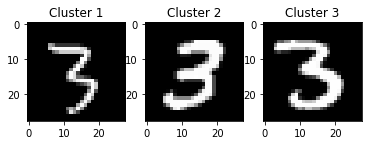

In [41]:
x_0_c1, y_0_c1, x_0_c2, y_0_c2, x_0_c3, y_0_c3 = create_kmeans_clusters(data[0][0], data[0][1])
fig, axs = plt.subplots(1, 3)
axs[0].imshow(x_0_c1[0].reshape(28,28),cmap='gray')
axs[0].set_title('Cluster 1')
axs[1].imshow(x_0_c2[0].reshape(28,28),cmap='gray')
axs[1].set_title('Cluster 2')
axs[2].imshow(x_0_c3[0].reshape(28,28),cmap='gray')
axs[2].set_title('Cluster 3')

Text(0.5, 1.0, 'Cluster 3')

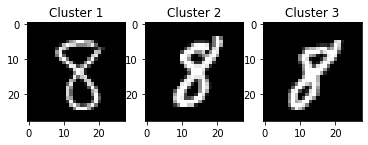

In [42]:
x_6_c1, y_6_c1, x_6_c2, y_6_c2, x_6_c3, y_6_c3 = create_kmeans_clusters(data[1][0], data[1][1])
fig, axs = plt.subplots(1, 3)
axs[0].imshow(x_6_c1[0].reshape(28,28),cmap='gray')
axs[0].set_title('Cluster 1')
axs[1].imshow(x_6_c2[0].reshape(28,28),cmap='gray')
axs[1].set_title('Cluster 2')
axs[2].imshow(x_6_c3[0].reshape(28,28),cmap='gray')
axs[2].set_title('Cluster 3')

### Creation of individual train sets for the clients, global train set for the SVM model and a global test set containing the data from all the clusters



In [87]:
clients_X,clients_y,X_test,y_test = get_clients(data[0][0], data[1][0], n_clients = 3)

In [88]:
xtrain_gl, ytrain_gl = get_total_from_clients(clients_X,clients_y)

### Federated learning model and SVM model training

#### Training the models without validation & with avg aggregator

In [45]:
f_svm = Federated_SVM(n_clients = 3, val=False, n_iters=150,opt='stochastic_GD')
f_svm.create_clients(clients_X,clients_y,X_test,y_test)

In [46]:
clf = SVM(xtrain_gl, ytrain_gl, X_test, y_test, val=False,n_iters=1000,opt='stochastic_GD')
clf.fit()
print(clf.accuracy())

96.67262969588552


In [47]:
f_svm.fit(10,f_svm.average_aggregator)

global round 1
client 1 79.17710196779964
client 2 81.18067978533094
client 3 73.20214669051879
global test acc 95.59928443649373
global round 2
client 1 79.35599284436495
client 2 80.35778175313058
client 3 72.41502683363149
global test acc 95.59928443649373
global round 3
client 1 79.2128801431127
client 2 81.18067978533094
client 3 72.80858676207514
global test acc 95.59928443649373
global round 4
client 1 78.74776386404292
client 2 81.1449016100179
client 3 72.73703041144901
global test acc 95.59928443649373
global round 5
client 1 78.6046511627907
client 2 80.82289803220036
client 3 73.23792486583184
global test acc 95.67084078711986
global round 6
client 1 79.24865831842575
client 2 80.46511627906978
client 3 72.88014311270126
global test acc 95.67084078711986
global round 7
client 1 79.5706618962433
client 2 80.82289803220036
client 3 73.16636851520573
global test acc 95.74239713774597
global round 8
client 1 79.5706618962433
client 2 81.824686940966
client 3 72.77280858676207
g

In [48]:
f_svm = Federated_SVM(n_clients = 3, val=False, n_iters=150,opt='batch_GD')
f_svm.create_clients(clients_X,clients_y,X_test,y_test)

In [49]:
clf = SVM(xtrain_gl, ytrain_gl, X_test, y_test, val=False,n_iters=1000,opt='batch_GD')
clf.fit()
print(clf.accuracy())

93.52415026833631


In [50]:
f_svm.fit(10,f_svm.average_aggregator)

global round 1
client 1 78.64042933810376
client 2 82.32558139534883
client 3 76.63685152057245
global test acc 89.3381037567084
global round 2
client 1 90.80500894454383
client 2 88.87298747763865
client 3 83.61359570661897
global test acc 90.80500894454383
global round 3
client 1 92.4865831842576
client 2 91.0912343470483
client 3 86.47584973166369
global test acc 91.73524150268337
global round 4
client 1 93.34525939177102
client 2 91.91413237924866
client 3 88.51520572450805
global test acc 92.77280858676208
global round 5
client 1 93.84615384615384
client 2 92.41502683363149
client 3 90.16100178890876
global test acc 93.30948121645795
global round 6
client 1 94.13237924865831
client 2 92.84436493738819
client 3 91.27012522361359
global test acc 93.59570661896244
global round 7
client 1 94.38282647584974
client 2 93.34525939177102
client 3 92.20035778175313
global test acc 93.7030411449016
global round 8
client 1 94.59749552772809
client 2 93.84615384615384
client 3 92.8443649373881

In [51]:
f_svm = Federated_SVM(n_clients = 3, val=False, n_iters=150,opt='mini_batch_GD')
f_svm.create_clients(clients_X,clients_y,X_test,y_test)

In [54]:
clf = SVM(xtrain_gl, ytrain_gl, X_test, y_test, val=False,n_iters=1000,opt='mini_batch_GD')
clf.fit()
print(clf.accuracy())

93.38103756708408


In [55]:
f_svm.fit(10,f_svm.average_aggregator)

global round 1
client 1 76.56529516994634
client 2 80.39355992844365
client 3 73.4525939177102
global test acc 95.74239713774597
global round 2
client 1 77.67441860465117
client 2 81.18067978533094
client 3 72.6654740608229
global test acc 95.74239713774597
global round 3
client 1 79.10554561717352
client 2 79.32021466905188
client 3 72.4865831842576
global test acc 95.74239713774597
global round 4
client 1 75.77817531305904
client 2 79.39177101967799
client 3 73.34525939177102
global test acc 95.95706618962433
global round 5
client 1 76.49373881932021
client 2 80.0
client 3 73.09481216457961
global test acc 95.95706618962433
global round 6
client 1 77.92486583184257
client 2 81.32379248658317
client 3 73.48837209302326
global test acc 95.95706618962433
global round 7
client 1 80.28622540250447
client 2 78.46153846153847
client 3 74.70483005366727
global test acc 95.9928443649374
global round 8
client 1 78.81932021466905
client 2 81.10912343470483
client 3 73.09481216457961
global test

#### Training the models with various validation & with avg aggregator & with batch GD

In [56]:
f_svm = Federated_SVM(n_clients = 3, val=False, n_iters=150,opt='batch_GD')
f_svm.create_clients(clients_X,clients_y,X_test,y_test)

In [57]:
clf = SVM(xtrain_gl, ytrain_gl, X_test, y_test, val=False, n_iters=1000,opt='batch_GD')
clf.fit()
print(clf.accuracy())

93.52415026833631


In [58]:
f_svm.fit(10,f_svm.average_aggregator)

global round 1
client 1 78.64042933810376
client 2 82.32558139534883
client 3 76.63685152057245
global test acc 89.3381037567084
global round 2
client 1 90.80500894454383
client 2 88.87298747763865
client 3 83.61359570661897
global test acc 90.80500894454383
global round 3
client 1 92.4865831842576
client 2 91.0912343470483
client 3 86.47584973166369
global test acc 91.73524150268337
global round 4
client 1 93.34525939177102
client 2 91.91413237924866
client 3 88.51520572450805
global test acc 92.77280858676208
global round 5
client 1 93.84615384615384
client 2 92.41502683363149
client 3 90.16100178890876
global test acc 93.30948121645795
global round 6
client 1 94.13237924865831
client 2 92.84436493738819
client 3 91.27012522361359
global test acc 93.59570661896244
global round 7
client 1 94.38282647584974
client 2 93.34525939177102
client 3 92.20035778175313
global test acc 93.7030411449016
global round 8
client 1 94.59749552772809
client 2 93.84615384615384
client 3 92.8443649373881

In [59]:
f_svm = Federated_SVM(n_clients = 3, val=True, n_iters=150,opt='batch_GD', val_type='cross_val')
f_svm.create_clients(clients_X,clients_y,X_test,y_test)

In [60]:
clf = SVM(xtrain_gl, ytrain_gl, X_test, y_test, val=True, n_iters=1000,opt='batch_GD', val_type='cross_val')
clf.fit()
print(clf.accuracy())

93.77459749552773


In [61]:
f_svm.fit(10,f_svm.average_aggregator)

global round 1
client 1 78.2468694096601
client 2 82.46869409660107
client 3 76.6010733452594
global test acc 89.37388193202148
global round 2
client 1 90.62611806797854
client 2 89.12343470483005
client 3 83.50626118067979
global test acc 90.76923076923077
global round 3
client 1 92.41502683363149
client 2 90.94812164579606
client 3 86.47584973166369
global test acc 91.80679785330949
global round 4
client 1 93.20214669051879
client 2 91.98568872987478
client 3 88.479427549195
global test acc 92.80858676207512
global round 5
client 1 93.81037567084078
client 2 92.27191413237925
client 3 90.08944543828264
global test acc 93.38103756708408
global round 6
client 1 94.20393559928443
client 2 92.91592128801432
client 3 91.4490161001789
global test acc 93.7030411449016
global round 7
client 1 94.4901610017889
client 2 93.38103756708408
client 3 92.37924865831843
global test acc 93.77459749552773
global round 8
client 1 94.59749552772809
client 2 93.84615384615384
client 3 93.02325581395348
g

In [89]:
f_svm = Federated_SVM(n_clients = 3, val=True, n_iters=150, val_type='k_fold',opt='batch_GD', k=5)
f_svm.create_clients(clients_X,clients_y,X_test,y_test)

In [63]:
clf = SVM(xtrain_gl, ytrain_gl, X_test, y_test, n_iters=1000, val=True,opt='batch_GD', val_type='k_fold', k=5)
clf.fit()
print(clf.accuracy())

93.55992844364937
93.52415026833631
93.66726296958855
93.6314847942755
93.6314847942755
93.6314847942755


In [90]:
f_svm.fit(10,f_svm.average_aggregator)

global round 1
79.85688729874776
80.28622540250447
80.14311270125224
80.35778175313058
80.10733452593918
client 1 80.28622540250447
83.5778175313059
83.29159212880143
83.43470483005366
83.29159212880143
83.3273703041145
client 2 83.29159212880143
75.95706618962433
75.88550983899822
76.02862254025044
76.06440071556351
75.99284436493738
client 3 76.06440071556351
global test acc 89.48121645796064
global round 2
90.87656529516994
90.76923076923077
90.7334525939177
90.91234347048301
90.69767441860465
client 1 90.91234347048301
89.19499105545617
89.30232558139535
89.30232558139535
89.23076923076924
89.23076923076924
client 2 89.30232558139535
83.18425760286226
83.07692307692308
83.14847942754919
83.11270125223614
83.11270125223614
client 3 83.07692307692308
global test acc 90.59033989266547
global round 3
92.45080500894454
92.41502683363149
92.37924865831843
92.41502683363149
92.3076923076923
client 1 92.37924865831843
91.01967799642217
90.98389982110913
91.12701252236135
90.94812164579606


#### Training models with various aggregators & without val & with batch gd


In [91]:
f_svm = Federated_SVM(n_clients = 3, val=False, n_iters=150,opt='batch_GD')
f_svm.create_clients(clients_X,clients_y,X_test,y_test)

In [66]:
clf = SVM(xtrain_gl, ytrain_gl, X_test, y_test, val=False, n_iters=1000,opt='batch_GD')
clf.fit()
print(clf.accuracy())

93.52415026833631


In [92]:
f_svm.fit(10,f_svm.highest_aggregator)

global round 1
client 1 80.28622540250447
client 2 83.36314847942755
client 3 75.88550983899822
global test acc 83.36314847942755
global round 2
client 1 89.08765652951699
client 2 82.86225402504472
client 3 85.79606440071557
global test acc 89.08765652951699
global round 3
client 1 89.37388193202148
client 2 87.47763864042933
client 3 90.51878354203936
global test acc 90.51878354203936
global round 4
client 1 92.4865831842576
client 2 91.59212880143113
client 3 88.33631484794276
global test acc 92.4865831842576
global round 5
client 1 92.91592128801432
client 2 92.98747763864043
client 3 90.62611806797854
global test acc 92.98747763864043
global round 6
client 1 93.77459749552773
client 2 92.70125223613596
client 3 92.16457960644007
global test acc 93.77459749552773
global round 7
client 1 93.52415026833631
client 2 92.70125223613596
client 3 93.13059033989266
global test acc 93.77459749552773
global round 8
client 1 93.02325581395348
client 2 92.70125223613596
client 3 93.63148479427

In [68]:
f_svm = Federated_SVM(n_clients = 3, val=False, n_iters=150,opt='batch_GD')
f_svm.create_clients(clients_X,clients_y,X_test,y_test)

In [70]:
f_svm.fit(10,f_svm.random_aggregator)

global round 1
client 1 78.64042933810376
client 2 82.32558139534883
client 3 76.63685152057245
global test acc 85.43828264758497
global round 2
client 1 91.16279069767442
client 2 86.83363148479427
client 3 81.1449016100179
global test acc 85.79606440071557
global round 3
client 1 91.91413237924866
client 2 87.62075134168158
client 3 82.1824686940966
global test acc 88.87298747763865
global round 4
client 1 92.66547406082289
client 2 89.94633273703042
client 3 85.83184257602863
global test acc 90.4830053667263
global round 5
client 1 93.52415026833631
client 2 91.520572450805
client 3 87.83542039355993
global test acc 92.84436493738819
global round 6
client 1 93.13059033989266
client 2 90.76923076923077
client 3 87.79964221824686
global test acc 92.95169946332737
global round 7
client 1 91.27012522361359
client 2 89.37388193202148
client 3 88.08586762075134
global test acc 92.95169946332737
global round 8
client 1 91.37745974955277
client 2 91.16279069767442
client 3 85.9391771019678


In [71]:
f_svm = Federated_SVM(n_clients = 3, val=False, n_iters=150,opt='batch_GD')
f_svm.create_clients(clients_X,clients_y,X_test,y_test)

In [73]:
f_svm.fit(10,f_svm.average_aggregator)

global round 1
client 1 78.64042933810376
client 2 82.32558139534883
client 3 76.63685152057245
global test acc 89.3381037567084
global round 2
client 1 90.80500894454383
client 2 88.87298747763865
client 3 83.61359570661897
global test acc 90.80500894454383
global round 3
client 1 92.4865831842576
client 2 91.0912343470483
client 3 86.47584973166369
global test acc 91.73524150268337
global round 4
client 1 93.34525939177102
client 2 91.91413237924866
client 3 88.51520572450805
global test acc 92.77280858676208
global round 5
client 1 93.84615384615384
client 2 92.41502683363149
client 3 90.16100178890876
global test acc 93.30948121645795
global round 6
client 1 94.13237924865831
client 2 92.84436493738819
client 3 91.27012522361359
global test acc 93.59570661896244
global round 7
client 1 94.38282647584974
client 2 93.34525939177102
client 3 92.20035778175313
global test acc 93.7030411449016
global round 8
client 1 94.59749552772809
client 2 93.84615384615384
client 3 92.8443649373881